## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [3]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
#df_comp=df_comp.fillna(method='ffill') deprecated
df_comp=df_comp.ffill()

In [4]:
df_comp['market_value']=df_comp.ftse

In [5]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
sts.adfuller(df.market_value)

(np.float64(-1.904155141883686),
 np.float64(0.3301089327702835),
 6,
 5014,
 {'1%': np.float64(-3.4316548765428174),
  '5%': np.float64(-2.8621166146845334),
  '10%': np.float64(-2.5670769326348926)},
 np.float64(54854.15304507557))

Como podemos ver $-1.904155141883686$ es mayor que cualquiera de los valores criticos, por lo que no rechazamos la hipotesis nula. Así mo podemos asumir que la serie sea estacionaría. Ademas el $p$ valor el mayor que los valores de significación.

## Creating Returns

Hacemos una transformación de los datos, una transformación que se suele hacer en datos de mercado es convertir los precios en datos de retorno. Los retornos es un porcentaje de cambio de los precios consecutivos.

In [9]:
df['returns'] = df.market_value.pct_change(1)*100 #100 para que sea porcentaje (pct_change es porcentaje de cambio) y 1 para que sea diario

In [10]:
df.head()

,market_value,returns
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166


In [13]:
df = df.iloc[1:]
sts.adfuller(df.returns)

(np.float64(-12.770265719497264),
 np.float64(7.798058336037375e-24),
 32,
 4987,
 {'1%': np.float64(-3.431661944885779),
  '5%': np.float64(-2.8621197374408225),
  '10%': np.float64(-2.5670785949998973)},
 np.float64(15696.767245697501))

Como podemos ver los valores criticos son menores que el estadisco de prueba, $-12.770265719497264$ asi podemos rechazar la ipotesis nula, por otro lado tambien tenemos que el $p_{valor} = (7.798058336037375)^{-24} $ es menor que los valores de signicación.

## ACF for Returns

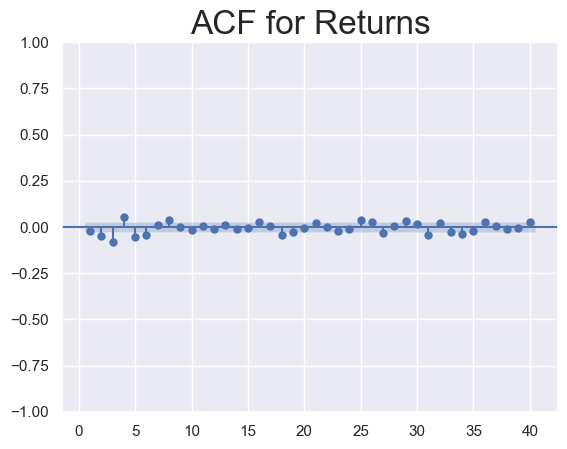

In [14]:
sgt.plot_acf(df.returns, zero = False, lags = 40)
plt.title("ACF for Returns", size=24)
plt.show()

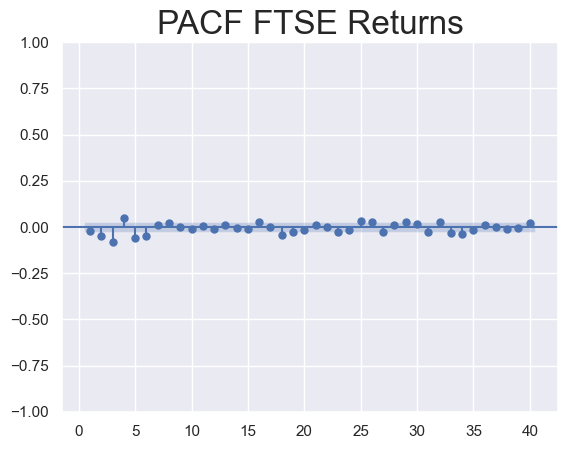

In [15]:
sgt.plot_pacf(df.returns, lags = 40, zero = False, method = ('ols'))
plt.title("PACF FTSE Returns", size=24)
plt.show()

Si quisieramos aplicar un modelo autorregresivo a nuestra serie de retornos, tomariamos mas en cuenta la función de autocorrelación parcial, ya que como vimos en la conversión de nuestros datos, consideramos los retornos por lo que necesitamos tener una mejor idea de como se relacionan los datos de una forma mas directa.

Como vemos, los primeros 6 retrazos son los que aportan un mayor grado de significación, por lo que podríamos considerar esos para investigar.



# AR(1)

In [19]:
from statsmodels.tsa.arima.model import ARIMA

In [33]:
model_ar = ARIMA(df.returns, order=(1, 0, 0))
results_ar = model_ar.fit() # ajusta el modelo
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7929.749
Date:                Tue, 08 Jul 2025   AIC                          15865.497
Time:                        05:16:48   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.143      0.253      -0.013       0.051
ar.L1         -0.0230      0.009     -2.697      0.007      -0.040      -0.006
sigma2         1.3790      0.014    100.092      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7872.72
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Observamos lo siguiente.
para la constante $p=0.253 > 0.05$ luego el $p-valor$ no es significativamente distinto de cero, ademas $o\in [-0.013, 0.051] $ por lo que nos da una mayor validación. 

Para el coeficiente de retrazo ar.L1 podemos ver que que su valor es significativo en nuestro modelo.

In [34]:
df.loc[:, 'res_price'] = results_ar.resid

In [35]:
sts.adfuller(df.res_price)

(np.float64(-12.782788720769746),
 np.float64(7.354275022448148e-24),
 32,
 4987,
 {'1%': np.float64(-3.431661944885779),
  '5%': np.float64(-2.8621197374408225),
  '10%': np.float64(-2.5670785949998973)},
 np.float64(15696.449439368527))

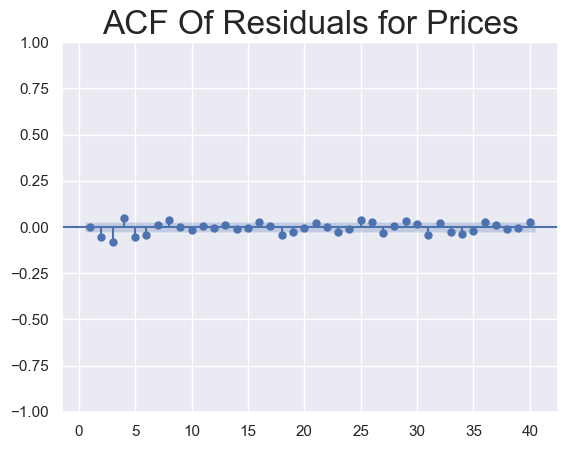

In [36]:
sgt.plot_acf(df.res_price, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices",size=24)
plt.show()

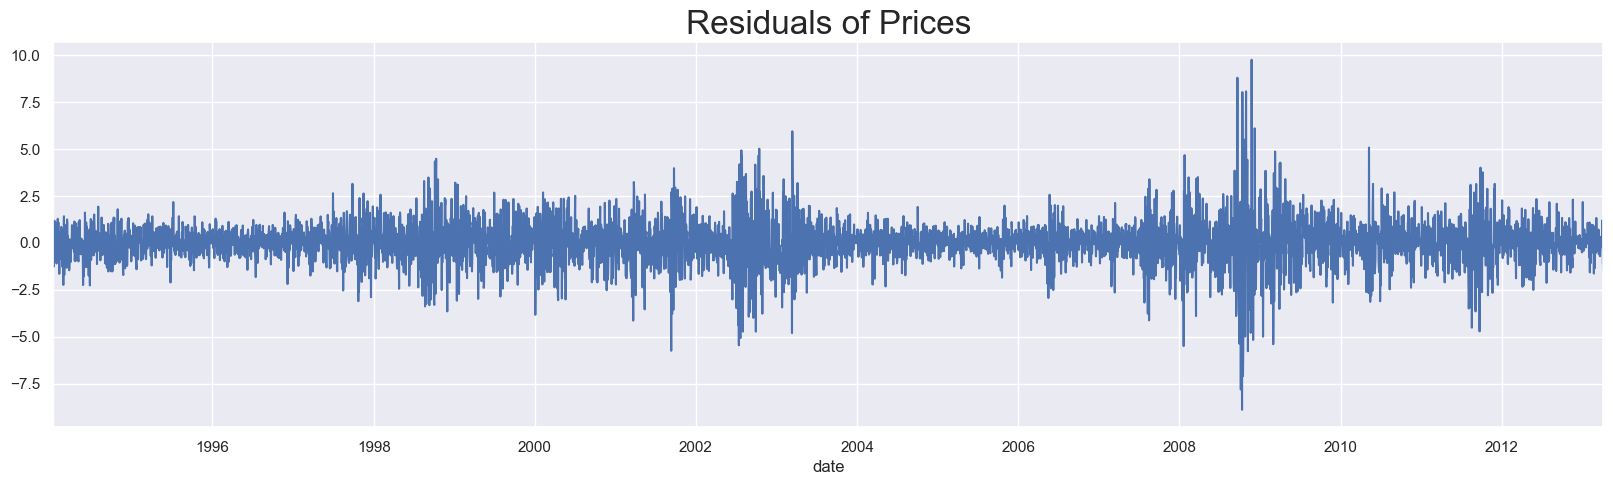

In [37]:
df.res_price[1:].plot(figsize=(20,5))
plt.title("Residuals of Prices",size=24)
plt.show()

Aunque el modelo AR(1) es significativo, no es el mejor modelo para nuestros datos. Dado que al observar los residuos la función de autocorrelación parcial no es significativa y pese a que es ruido blanco, concluimos que no es un buen modelo para nuestros datos.

### Veamos un modelos de orden 6

In [28]:
model_ar_six = ARIMA(df.returns, order=(6, 0, 0))
results_ar_six = model_ar_six.fit() # ajusta el modelo
results_ar_six.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -7886.945
Date:                Tue, 08 Jul 2025   AIC                          15789.890
Time:                        04:47:20   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.324      0.186      -0.009       0.047
ar.L1         -0.0245      0.009     -2.640      0.008      -0.043      -0.006
ar.L2         -0.0523      0.008     -6.505      0.000      -0.068      -0.037
ar.L3         -0.0870      0.008    -10.853      0.000      -0.103      -0.071
ar.L4          0.0424      0.008      5.133      0.000       0.026       0.059
ar.L5         -0.0607      0.008     -7.568      0.000      -0.076      -0.045
ar.L6         -0.0466      0.009     -5.216      0.000      -0.064      -0.029
sigma2         1.3557      0.015     92.513      0.000       1.327       1.384
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6487.37
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Se observa que para los coeficientes del ar.L1 a ar.L6, son significativos y para el coeficiente const tenemos que no es significativo o no tenemos la suficiente evidencia para afirmar que sea distinto de cero, por lo caul para este aceptamos la hipotesis nula.

In [38]:
df.loc[:, 'res_price_ar_six'] = results_ar_six.resid
sts.adfuller(df.res_price_ar_six)

(np.float64(-70.78411835831812),
 0.0,
 0,
 5019,
 {'1%': np.float64(-3.4316535759402753),
  '5%': np.float64(-2.8621160400844468),
  '10%': np.float64(-2.567076626752987)},
 np.float64(15692.570807333239))

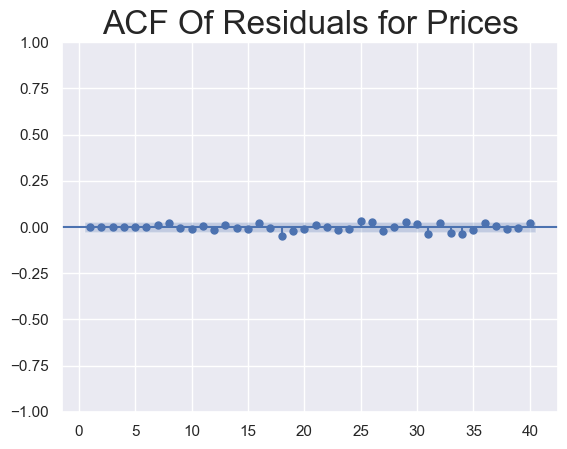

In [39]:
sgt.plot_acf(df.res_price_ar_six, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices",size=24)
plt.show()

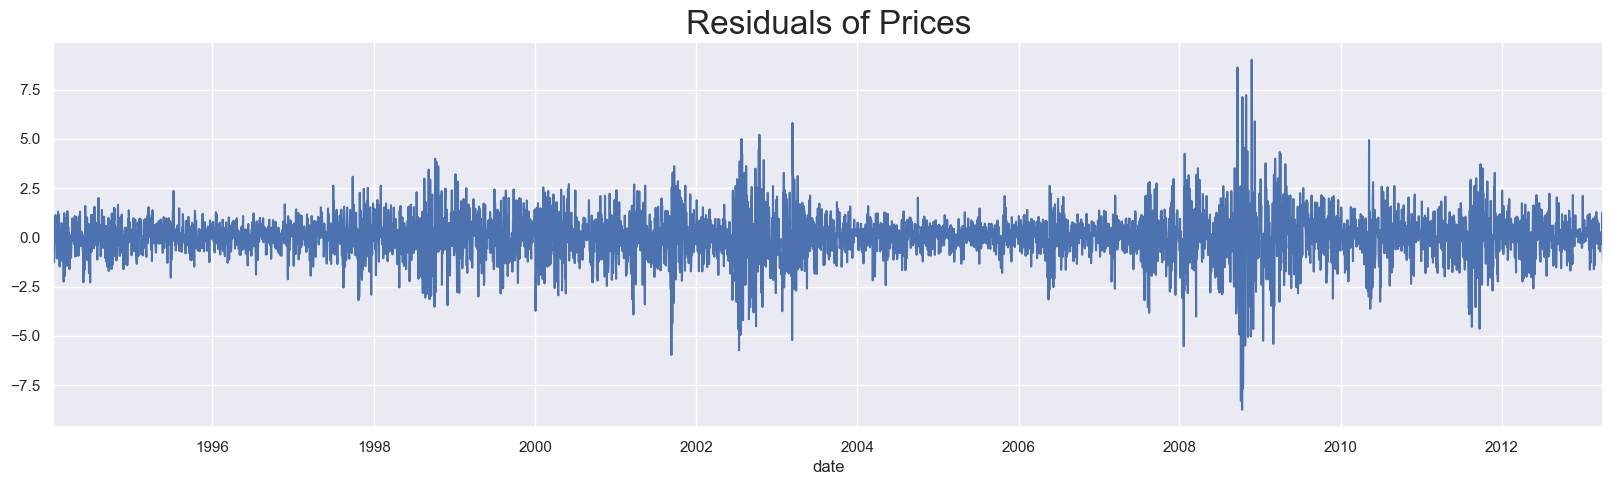

In [31]:
df.res_price_ar_six.plot(figsize=(20,5))
plt.title("Residuals of Prices",size=24)
plt.show()

Podemos ver que los residuales de nuestro modelo de orden 6, son ruido blanco y la funcion autocorrelación parcial es significativa, por lo que podemos decir que nuestro modelo es adecuado.

## MA(1) for Returns

In [12]:
model_ret_ma_1 = ARMA(df.returns[1:], order=(0,1))
results_ret_ma_1 = model_ret_ma_1.fit()
results_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 1)   Log Likelihood               -7929.595
Method:                       css-mle   S.D. of innovations              1.174
Date:                Tue, 21 Apr 2020   AIC                          15865.190
Time:                        07:53:47   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.162      0.245      -0.013       0.050
ma.L1.returns    -0.0257      0.015     -1.720      0.086      -0.055       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           38.8549           +0.0000j           38.8549            0.0000
-----------------------------------------------------------------------------
"""

## Higher-Lag MA Models for Returns

In [13]:
model_ret_ma_2 = ARMA(df.returns[1:], order=(0,2))
results_ret_ma_2 = model_ret_ma_2.fit()
print(results_ret_ma_2.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_1, results_ret_ma_2)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 2)   Log Likelihood               -7922.864
Method:                       css-mle   S.D. of innovations              1.173
Date:                Tue, 21 Apr 2020   AIC                          15853.728
Time:                        08:07:54   BIC                          15879.812
Sample:                    01-10-1994   HQIC                         15862.868
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.239      0.215      -0.011       0.049
ma.L1.returns    -0.0327      0.014     -2.297      0.022      -0.061      -0.005
ma.L2.returns    -0.0502      0.014     

In [14]:
model_ret_ma_3 = ARMA(df.returns[1:], order=(0,3))
results_ret_ma_3 = model_ret_ma_3.fit()
print(results_ret_ma_3.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_2, results_ret_ma_3)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 3)   Log Likelihood               -7904.317
Method:                       css-mle   S.D. of innovations              1.168
Date:                Tue, 21 Apr 2020   AIC                          15818.634
Time:                        08:11:27   BIC                          15851.240
Sample:                    01-10-1994   HQIC                         15830.060
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.376      0.169      -0.008       0.046
ma.L1.returns    -0.0203      0.014     -1.423      0.155      -0.048       0.008
ma.L2.returns    -0.0556      0.013     

In [15]:
model_ret_ma_4 = ARMA(df.returns[1:], order=[0,4])
results_ret_ma_4 = model_ret_ma_4.fit()
print(results_ret_ma_4.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_3, results_ret_ma_4)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 4)   Log Likelihood               -7898.773
Method:                       css-mle   S.D. of innovations              1.167
Date:                Tue, 21 Apr 2020   AIC                          15809.547
Time:                        08:13:30   BIC                          15848.674
Sample:                    01-10-1994   HQIC                         15823.257
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.305      0.192      -0.009       0.047
ma.L1.returns    -0.0203      0.014     -1.443      0.149      -0.048       0.007
ma.L2.returns    -0.0551      0.014     

In [16]:
model_ret_ma_5 = ARMA(df.returns[1:], order=[0,5])
results_ret_ma_5 = model_ret_ma_5.fit()
print(results_ret_ma_5.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_4, results_ret_ma_5)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 5)   Log Likelihood               -7892.823
Method:                       css-mle   S.D. of innovations              1.166
Date:                Tue, 21 Apr 2020   AIC                          15799.645
Time:                        08:13:40   BIC                          15845.294
Sample:                    01-10-1994   HQIC                         15815.641
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.376      0.169      -0.008       0.046
ma.L1.returns    -0.0262      0.014     -1.851      0.064      -0.054       0.002
ma.L2.returns    -0.0497      0.014     

In [17]:
model_ret_ma_6 = ARMA(df.returns[1:], order=[0,6])
results_ret_ma_6 = model_ret_ma_6.fit()
print(results_ret_ma_6.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_5, results_ret_ma_6)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 6)   Log Likelihood               -7889.221
Method:                       css-mle   S.D. of innovations              1.165
Date:                Tue, 21 Apr 2020   AIC                          15794.442
Time:                        08:13:49   BIC                          15846.612
Sample:                    01-10-1994   HQIC                         15812.723
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.430      0.153      -0.007       0.045
ma.L1.returns    -0.0237      0.014     -1.682      0.093      -0.051       0.004
ma.L2.returns    -0.0486      0.014     

In [18]:
model_ret_ma_7 = ARMA(df.returns[1:], order=[0,7])
results_ret_ma_7 = model_ret_ma_7.fit()
print(results_ret_ma_7.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_6, results_ret_ma_7)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 7)   Log Likelihood               -7889.046
Method:                       css-mle   S.D. of innovations              1.165
Date:                Tue, 21 Apr 2020   AIC                          15796.091
Time:                        08:13:57   BIC                          15854.782
Sample:                    01-10-1994   HQIC                         15816.657
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.418      0.156      -0.007       0.045
ma.L1.returns    -0.0247      0.014     -1.739      0.082      -0.052       0.003
ma.L2.returns    -0.0488      0.014     

In [19]:
model_ret_ma_8 = ARMA(df.returns[1:], order=[0,8])
results_ret_ma_8 = model_ret_ma_8.fit()
print(results_ret_ma_8.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_7, results_ret_ma_8)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 8)   Log Likelihood               -7885.603
Method:                       css-mle   S.D. of innovations              1.164
Date:                Tue, 21 Apr 2020   AIC                          15791.205
Time:                        08:15:57   BIC                          15856.417
Sample:                    01-10-1994   HQIC                         15814.056
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.364      0.173      -0.008       0.046
ma.L1.returns    -0.0238      0.014     -1.688      0.091      -0.051       0.004
ma.L2.returns    -0.0495      0.014     

In [20]:
LLR_test(results_ret_ma_6, results_ret_ma_8, DF = 2)

0.027

## Residuals for Returns

In [0]:
df['res_ret_ma_8'] = results_ret_ma_8.resid[1:]

In [23]:
print("The mean of the residuals is " + str(round(df.res_ret_ma_8.mean(),3)) + "\nThe variance of the residuals is " + str(round(df.res_ret_ma_8.var(),3)))

The mean of the residuals is -0.0
The variance of the residuals is 1.356


In [24]:
round(sqrt(df.res_ret_ma_8.var()),3)

1.164

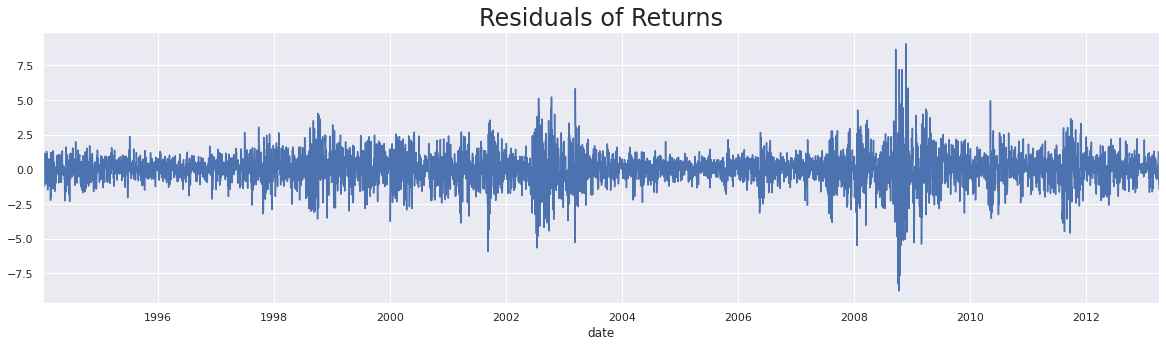

In [25]:
df.res_ret_ma_8[1:].plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

In [26]:
sts.adfuller(df.res_ret_ma_8[2:])

(-70.83581502434359,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '10%': -2.567076687880585,
  '5%': -2.8621161549128313},
 15684.052185059796)

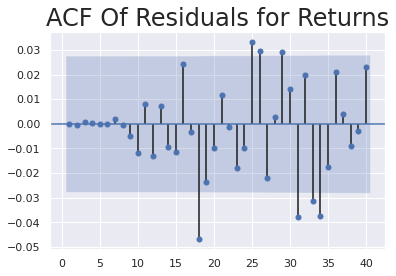

In [27]:
sgt.plot_acf(df.res_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

## Normalized Prices

In [0]:
benchmark = df.market_value.iloc[0]
df['norm'] = df.market_value.div(benchmark).mul(100)

In [63]:
df.head()

,market_value,returns,res_ret_ma_8,norm
date,,,,
1994-01-07,3445.98,NaN,NaN,100.000000
1994-01-10,3440.58,-0.156704,NaN,99.843296
1994-01-11,3413.77,-0.779229,-0.802111,99.065288
1994-01-12,3372.02,-1.222988,-1.269464,97.853731
1994-01-13,3360.01,-0.356166,-0.464780,97.505209


In [64]:
sts.adfuller(df['norm'])

(-1.9041551418836287,
 0.3301089327703105,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '10%': -2.5670769326348926,
  '5%': -2.8621166146845334},
 19541.17381480549)

## Normalized Returns

In [0]:
bench_ret = df.returns.iloc[1]
df['norm_ret'] = df.returns.div(bench_ret).mul(100)

In [71]:
df.head()

,market_value,returns,res_ret_ma_8,norm,norm_ret
date,,,,,
1994-01-07,3445.98,NaN,NaN,100.000000,NaN
1994-01-10,3440.58,-0.156704,NaN,99.843296,20.110175
1994-01-11,3413.77,-0.779229,-0.802111,99.065288,100.000000
1994-01-12,3372.02,-1.222988,-1.269464,97.853731,156.948464
1994-01-13,3360.01,-0.356166,-0.464780,97.505209,45.707526


In [72]:
sts.adfuller(df.norm_ret[1:])

(-12.770265719497255,
 7.798058336037547e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '10%': -2.5670785949998973,
  '5%': -2.8621197374408225},
 64116.75100118076)

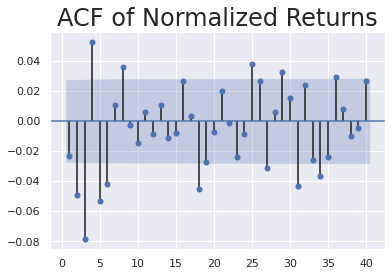

In [73]:
sgt.plot_acf(df.norm_ret[1:], zero = False, lags = 40)
plt.title("ACF of Normalized Returns",size=24)
plt.show()

In [74]:
model_norm_ret_ma_8 = ARMA(df.norm_ret[1:], order=(0,8))
results_norm_ret_ma_8 = model_norm_ret_ma_8.fit()
results_norm_ret_ma_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(0, 8)   Log Likelihood              -32255.797
Method:                       css-mle   S.D. of innovations            149.383
Date:                Tue, 21 Apr 2020   AIC                          64531.594
Time:                        10:27:33   BIC                          64596.806
Sample:                    01-10-1994   HQIC                         64554.445
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.4252      1.779     -1.363      0.173      -5.912       1.061
ma.L1.norm_ret    -0.0238      0.014     -1.688      0.091      -0.051       0.004
ma.L2.norm_ret    -0.0495      0.014     -3.514      0.000      -0.077      -0.022
ma.L3.norm_ret    -0.0847      0.014     -5.993      0.000      -0.112      -0.057
ma.L4.norm_ret     0.0488      0.014      3.440      0.001       0.021       0.077
ma.L5.norm_ret    -0.0518      0.014     -3.634      0.000      -0.080      -0.024
ma.L6.norm_ret    -0.0402      0.014     -2.787      0.005      -0.068      -0.012
ma.L7.norm_ret     0.0084      0.014      0.587      0.557      -0.020       0.036
ma.L8.norm_ret     0.0366      0.014      2.626      0.009       0.009       0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.4716           -0.4282j            1.5326           -0.0451
MA.2            1.4716           +0.4282j            1.5326            0.0451
MA.3            0.5944           -1.3169j            1.4448           -0.1825
MA.4            0.5944           +1.3169j            1.4448            0.1825
MA.5           -0.7318           -1.2736j            1.4689           -0.3330
MA.6           -0.7318           +1.2736j            1.4689            0.3330
MA.7           -1.4485           -0.6983j            1.6081           -0.4285
MA.8           -1.4485           +0.6983j            1.6081            0.4285
-----------------------------------------------------------------------------
"""

In [0]:
df['res_norm_ret_ma_8'] = results_norm_ret_ma_8.resid[1:]

In [76]:
sts.adfuller(df.res_norm_ret_ma_8[2:])

(-70.8358058987761,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '10%': -2.567076687880585,
  '5%': -2.8621161549128313},
 64094.32669974392)

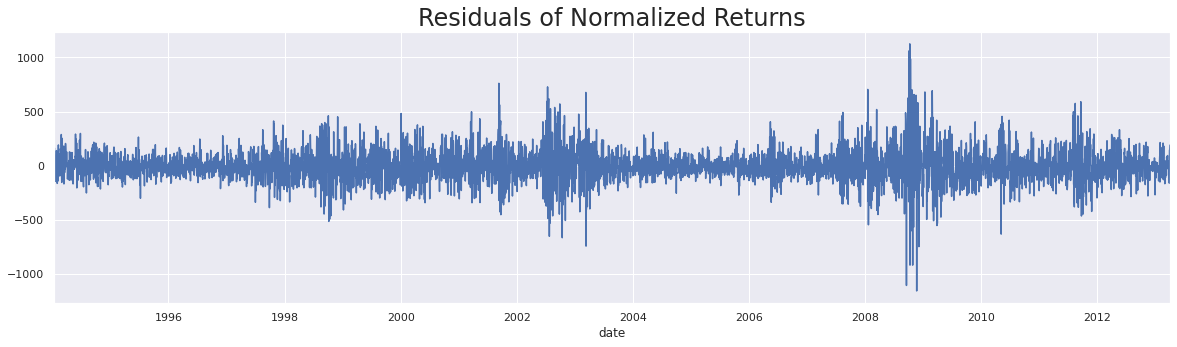

In [77]:
df.res_norm_ret_ma_8[1:].plot(figsize=(20,5))
plt.title("Residuals of Normalized Returns",size=24)
plt.show()

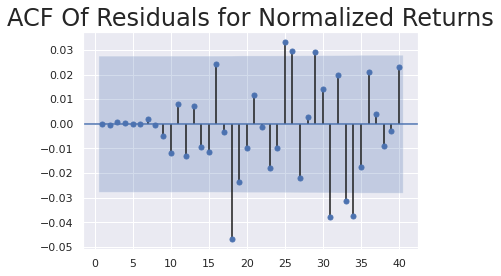

In [78]:
sgt.plot_acf(df.res_norm_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Normalized Returns",size=24)
plt.show()

## MA Models For Prices

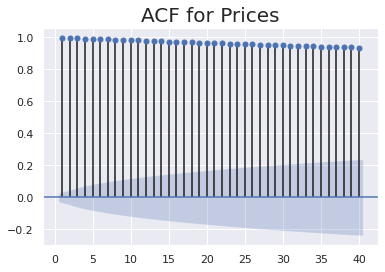

In [79]:
sgt.plot_acf(df.market_value, zero = False, lags = 40)
plt.title("ACF for Prices", size=20)
plt.show()

In [80]:
model_ma_1 = ARMA(df.market_value, order=(0,1))
results_ma_1 = model_ma_1.fit()
results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(0, 1)   Log Likelihood              -38629.000
Method:                       css-mle   S.D. of innovations            530.756
Date:                Tue, 21 Apr 2020   AIC                          77264.000
Time:                        10:33:21   BIC                          77283.564
Sample:                    01-07-1994   HQIC                         77270.856
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6652     14.660    347.192      0.000    5060.933    5118.397
ma.L1.market_value     0.9573      0.003    335.561      0.000       0.952       0.963
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0446           +0.0000j            1.0446            0.5000
-----------------------------------------------------------------------------
"""